# Style-Transfer with Pytorch
Code taken from [NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=style%20transfer).

## 1. Setup:

### 1.1. Import libs

In [41]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

import torchvision.models as models

import copy

import numpy as np

### 1.2. Choose machine

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.3. Define the desired size of the output image
Don't go too high 'cause this may stress your machine. Start small and work your way up, benchmarking your machine at the same time.

In [16]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

## 2. Load Image

### 2.1. Import and Rescale image
The `loader` simply imports the provided image and does a bit of resizing based on the `imsize` value. Then converts the image into a tensor. 

In [18]:
loader = transforms.Compose([
    transforms.Resize(imsize), # scale imported image
    transforms.ToTensor()])    # transform it into a torch tensor

We use a helper function to actually apply the loader onto the images we want to process:

In [19]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

For the purpose of this demontration I will use an image that represents the famous fortress of Koules. The Koules or Castello a Mare is a fortress located at the entrance of the old port of Heraklion, Crete, Greece. It was built by the Republic of Venice in the early 16th century, and is still in good condition today. A picture appears below:
![Koules](content_images/koules.jpg)

In [23]:
# Let's go ahead and load it
content_img = image_loader("content_images/koules.jpg")

As for the style, i will use a painting that I think will generate some interesting results; the Rain's Rustle II. This brightly colored depiction of a romantic stroll dispels myths associated with gloomy rain, as "Rain's Rustle II" presents an atmosphere of life and anticipation. Glistening pools of rainfall blanket the weaving pathway, reflecting the glimmers of light from ornate lamp posts. The tone and color of the leaves reveal the movement of the wind, creating a serene accent to your living room or office.
![Rain's Rustle](style_images/rains_rustle.jpg)

In [25]:
style_img = image_loader("style_images/rains_rustle.jpg")

Here comes the first issue. If you are trying to do this on your own, using your own images as I am, then the following assertion won't work.

In [33]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

AssertionError: we need to import style and content images of the same size

This is to be expected, given that:

In [27]:
print(style_img.size())

torch.Size([1, 3, 128, 204])


In [28]:
print(content_img.size())

torch.Size([1, 3, 128, 192])


This seems weird given the resizing applied in the data loader. However, the resizing assumes that the dimensions ratio of the input images is the same, i.e. for $p$, the content image and $s$, the style image:

$\frac{p_{width}}{p_{heightt}} = \frac{s_{width}}{s_{heightt}}$

But this is not the case:

In [36]:
content_image = Image.open("content_images/koules.jpg")

In [37]:
p_ratio = content_image.width/content_image.height
print("p_ratio={}".format(p_ratio))

p_ratio=1.5


In [35]:
style_image = Image.open("style_images/rains_rustle.jpg")

In [38]:
s_ratio = style_image.width/style_image.height
print("p_ratio={}".format(s_ratio))

p_ratio=1.594896331738437


So, we need to play around a bit with the dimensions of the style image to adjust this.

In [42]:
style_image = ImageOps.fit(style_image, (content_image.width, content_image.height))   # PIL.ImageOps.fit(image, size, method=0, bleed=0.0, centering=(0.5, 0.5)) where size – The requested output size in pixels, given as a (width, height) tuple.

Then following up on the remainign operations of then data loader helper:

In [44]:
style_img_unsqueezed = loader(style_image).unsqueeze(0)
style_img = style_img_unsqueezed.to(device, torch.float)

The style image is now, not only resized but has an equal ratio to the content image:

In [45]:
print(style_img.size())

torch.Size([1, 3, 128, 192])


In [46]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

It's always useful to visualise the process in all steps. To do that we need to be able to convert our tensor back to an image:

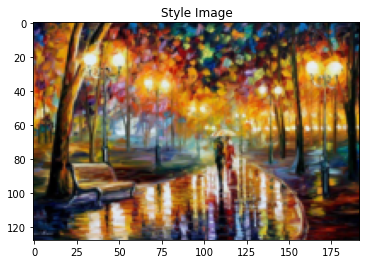

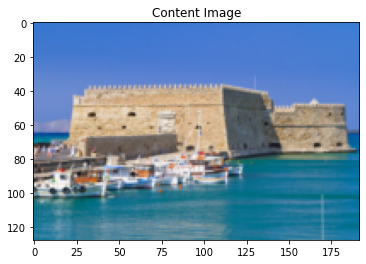

In [47]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')